# ADAroundTheWorld2023 - Milestone 3

## Imports

In [22]:
import pandas as pd
import networkx as nx
import seaborn as sns

from scripts.helpers import get_list_from_string_dict
from scripts.plotting import plot_example_graph

from bokeh.io import show
from bokeh.io.export import get_screenshot_as_png

In [2]:
from selenium import webdriver
import chromedriver_binary  # Adds chromedriver binary to path

## Table of Contents

Please do not try to click on them in GitHub as GitHub renders it differently and the links only work locally.

&emsp;&ensp;&ensp;[Abstract](#abstract)<br style="margin-bottom:0.5em;">
&emsp;&emsp;[1 - Preprocessing & Initial Analysis](#preprocess)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[1.1 - Preprocessing](#preprocessing-child)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[1.2 - Merging](#merging)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[1.3 - First Glance](#first-glance)<br style="margin-bottom:0.5em;">
&emsp;&emsp;[2 - Theory of Centrality Metrics](#theory)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[2.1 - Betweenness](#betweenness)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[2.2 - Degree](#degree)<br style="margin-bottom:0.5em;">
&emsp;&emsp;[3 - Creating Network Graphs](#creating-network)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[3.1 - Embeddings](#embeddings)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[3.1 - Classification](#classification)<br style="margin-bottom:0.1em;">
&emsp;&emsp;[4 - Correlation Analysis](#correlation-analysis)<br style="margin-bottom:0.1em;">
&emsp;&ensp;&ensp;[Summary](#summary)<br style="margin-bottom:0.1em;">


## Abstract <a class="anchor" id="abstract"></a>

TBD

## 1. Preprocessing & Initial Analysis <a class="anchor" id="preprocess"></a>

TBD

### 1.1 Preprocessing <a class="anchor" id="preprocessing-child"></a>

TBD

### 1.1.1 Movie Metadata

In [3]:
# specify the column names 
column_names = [
    'wikipedia_id', 'freebase_id', 'name', 'release_date', 
    'box_office_revenue', 'runtime', 'languages', 'countries', 'genres'
]
metadata_df = pd.read_table('data/raw/movie.metadata.tsv', names=column_names)
print(metadata_df.shape)
metadata_df.head(5)

(81741, 9)


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Few things come up first that needs to be done:
1. release date has **inconsistent formatting** -> let's use only year
2. we **don't need box-office revenue and runtime** for the analysis -> let's drop them
3. languages, countries and genres have **inconvenient formatting** -> let's fix that

In [4]:
# let's first check how many missing values do we have in release date
missing_perc_date = metadata_df.release_date.isna().sum() / metadata_df.shape[0] * 100
print(f'We have missing year for {round(missing_perc_date, 1)}% of data.')

We have missing year for 8.4% of data.


In [5]:
# let's now convert string to date
metadata_df['release_year'] = pd.to_datetime(metadata_df['release_date'], errors='coerce')

# remove the original column
# plus there might be some with inconsistent formatting in the newly created column
metadata_df.drop(columns='release_date', inplace=True)
metadata_df.dropna(subset=['release_year'], inplace=True)

# and now convert it to year as integer
metadata_df['release_year'] = metadata_df['release_year'].dt.year.astype(int)

metadata_df.head(5)

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983


In [6]:
# let's remove unnecessary columns
metadata_df.drop(columns=['box_office_revenue', 'runtime'], inplace=True)

In [7]:
# convert columns genres, languages and countries to list of strings
metadata_df['genres'] = metadata_df.genres.apply(get_list_from_string_dict)
metadata_df['languages'] = metadata_df.languages.apply(get_list_from_string_dict)
metadata_df['countries'] = metadata_df.countries.apply(get_list_from_string_dict)

metadata_df[['genres', 'languages', 'countries']].head(5)

,genres,languages,countries
0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America]
1,"[Mystery, Biographical film, Drama, Crime Drama]",[English Language],[United States of America]
2,"[Crime Fiction, Drama]",[Norwegian Language],[Norway]
3,"[Thriller, Erotic thriller, Psychological thri...",[English Language],[United Kingdom]
4,[Drama],[German Language],[Germany]


In [8]:
# let's now check the null-s 
print("Number of rows {}:".format(metadata_df.shape[0]))
(~metadata_df.astype(bool)).sum()

Number of rows 74838:


wikipedia_id        0
freebase_id         0
name                0
languages       10009
countries        5228
genres           1762
release_year        0
dtype: int64

Such method was used for checking nulls because `languages`, `countries` and `genres` might simply be empty lists.
As languages nor countries are in the principal role in the following analysis (we might not use them at all), 
we can keep them as they are for now and decide the strategy if need be.

### 1.1.2 Plot Summaries    

In [9]:
# let's read the file
plot_column_names = ['wikipedia_id', 'plot']
plot_df = pd.read_csv('data/raw/plot_summaries.txt', sep="\t", names=plot_column_names)
print(plot_df.shape)
plot_df.head(5)

(42303, 2)


,wikipedia_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [10]:
# let's check nan-s here
plot_df.isna().sum()

wikipedia_id    0
plot            0
dtype: int64

In [11]:
# check if any of the columns is not empty string in plots
empty_plots = (plot_df['plot'].apply(len) == 0).sum()
print(f'We have {empty_plots} plots that have empty plot description.')

We have 0 plots that have empty plot description.


### 1.1.3 IMDB Ratings

For IMDB, we need two files `title.ratings.tsv` and `title.basics.tsv`.

In [12]:
imdb_basics_df = pd.read_csv('data/raw/title.basics.tsv', sep='\t', low_memory=False)
print(imdb_basics_df.shape)
imdb_basics_df.head(5)

(10306126, 9)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [14]:
imdb_ratings_df = pd.read_csv('data/raw/title.ratings.tsv', sep='\t')
print(imdb_ratings_df.shape)
imdb_ratings_df.head(5)

(1367781, 3)


,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


In order to add ratings, we need first to merge two IMDB df-s.

In [15]:
# let's first keep only necessary titles
imdb_basics_df = imdb_basics_df[imdb_basics_df.titleType == 'movie']

# let's keep only necessary columns
imdb_basics_df = imdb_basics_df[['tconst', 'originalTitle', 'startYear']]

In [16]:
# now we can merge the two
imdb_df = pd.merge(imdb_basics_df, imdb_ratings_df, on='tconst', how='inner')
print(imdb_df.shape)
imdb_df.head(5)

(299786, 5)


,tconst,originalTitle,startYear,averageRating,numVotes
0,tt0000009,Miss Jerry,1894,5.3,207
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,5.3,484
2,tt0000502,Bohemios,1905,4.1,15
3,tt0000574,The Story of the Kelly Gang,1906,6.0,855
4,tt0000591,L'enfant prodigue,1907,5.0,21


In [17]:
# we don't need tconst anymore, let's drop it
imdb_df.drop(columns='tconst', inplace=True)

# let's rename the columns to avoid camelcase and sync with other df-s
imdb_df.rename(
    columns={
        'originalTitle': 'name',
        'startYear': 'release_year',
        'averageRating': 'rating',
        'numVotes': 'num_votes'
    },
    inplace=True
)

# let's fix some dtypes
imdb_df.release_year = pd.to_numeric(imdb_df.release_year, errors='coerce', downcast='integer')
imdb_df.dropna(subset='release_year', inplace=True)

imdb_df.name = imdb_df.name.astype(str)

In [18]:
# let's check nulls per column
imdb_df.isna().sum()

name            0
release_year    0
rating          0
num_votes       0
dtype: int64

### 1.2 Merging <a class="anchor" id="merging"></a>

Now that we have all the datasets preprocessed, let's merge them.

In [19]:
# merge plots with metadata
movies_plots_df = pd.merge(plot_df, metadata_df, on='wikipedia_id', how='inner')
movies_plots_df.head(5)

,wikipedia_id,plot,freebase_id,name,languages,countries,genres,release_year
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",/m/076w2lb,Taxi Blues,[Russian Language],"[France, Soviet Union, Russia]","[Drama, World cinema]",1990
1,31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,The Hunger Games,[English Language],[United States of America],"[Action/Adventure, Science Fiction, Action, Dr...",2012
2,20663735,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb,Narasimham,[Malayalam Language],[India],"[Musical, Action, Drama, Bollywood]",2000
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3,The Lemon Drop Kid,[English Language],[United States of America],"[Screwball comedy, Comedy]",1951
4,595909,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,A Cry in the Dark,[English Language],"[United States of America, Australia, New Zeal...","[Crime Fiction, Drama, Docudrama, World cinema...",1988


Since we need to use the year and movie name for merging, we first need to check if there are any duplicates in the year-name pairs. If there are some, we’d need to remove them as we cannot be sure without manually going through all of them, which one is correct.

In [20]:
# drop duplicated keys
movies_plots_df.drop_duplicates(subset=['name', 'release_year'], keep=False, inplace=True)
imdb_df.drop_duplicates(subset=['name', 'release_year'], keep=False, inplace=True)

In [21]:
# let's create lowercase titles for merging
movies_plots_df['name_lowercase'] = movies_plots_df.name.str.lower()
imdb_df['name_lowercase'] = imdb_df.name.str.lower()

# let's now merge
df = pd.merge(imdb_df, movies_plots_df, on=['name_lowercase', 'release_year'], how='inner')

# and now deal with lowecase names
df.drop(columns=['name_lowercase', 'name_y'], inplace=True)
df.rename(columns={'name_x': 'name'}, inplace=True)

print(df.shape)
df.head(5)

(22394, 10)


,name,release_year,rating,num_votes,wikipedia_id,plot,freebase_id,languages,countries,genres
0,Miss Jerry,1894.0,5.3,207,10109752,After finding out that her father is suffering...,/m/02q23xk,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
1,The Corbett-Fitzsimmons Fight,1897.0,5.3,484,28703057,The film no longer exists in its entirety; how...,/m/0czdh_n,[],[],[Sports]
2,The Story of the Kelly Gang,1906.0,6.0,855,142995,The Story of the Kelly Gangs tone is of sorrow...,/m/0120y4,[English Language],[Australia],"[Crime Fiction, Silent film, Biography, Indie,..."
3,Robbery Under Arms,1907.0,4.3,25,32986669,Key scenes of the film included the branding o...,/m/04p7yxx,[Silent film],[Australia],"[Silent film, Drama]"
4,"Captain Midnight, the Bush King",1911.0,5.4,18,32987200,Edgar Dalimore is the son of wealthy station o...,/m/0h569x9,[Silent film],[],[Silent film]


We now have finished with preprocessing and have 22394 rows with all the necessary data.

### 1.3 First Glance <a class="anchor" id="first-glance"></a>

Let's now understand the nature of our data and start with the descriptive statistics.

In [23]:
df.describe()

,release_year,rating,num_votes,wikipedia_id
count,22394.000000,22394.000000,2.239400e+04,2.239400e+04
mean,1982.243190,6.181531,2.651533e+04,1.309584e+07
std,25.264013,1.112262,1.033211e+05,1.093448e+07
min,1894.000000,1.200000,5.000000e+00,3.217000e+03
25%,1963.000000,5.600000,3.632500e+02,3.055782e+06
50%,1990.000000,6.300000,1.674000e+03,1.005270e+07
75%,2004.000000,6.900000,9.244000e+03,2.294357e+07
max,2014.000000,9.700000,2.816967e+06,3.749236e+07


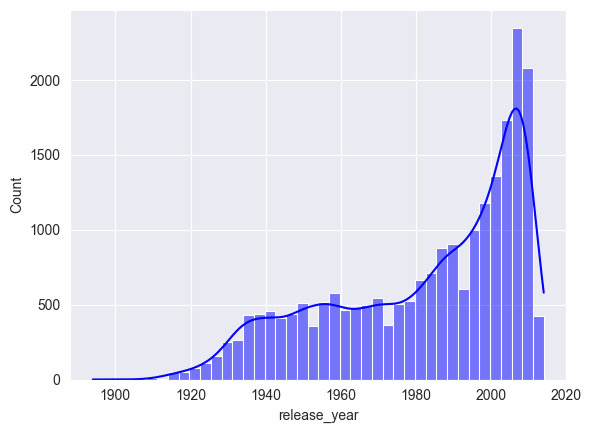

In [25]:
# plot the movie counts by year
_ = sns.histplot(df.release_year, kde=True, color='blue', label='treated')

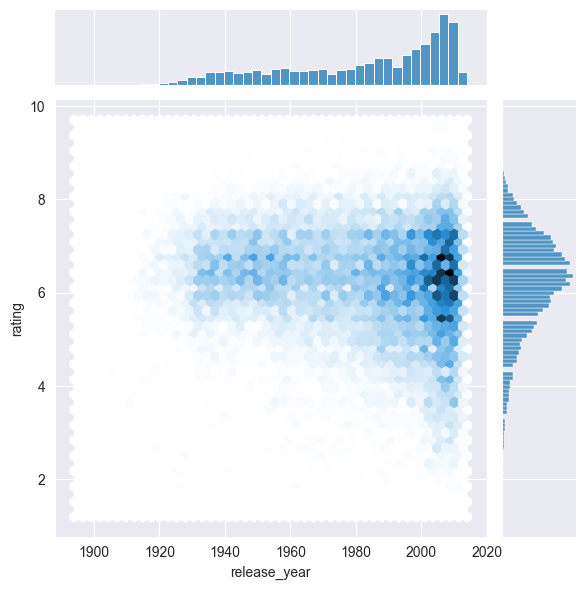

In [31]:
# let's see compare the IMDB rating with the year
_ = sns.jointplot(data=df, x='release_year', y='rating', kind='hex')

## 2. Theory of Centrality Metrics <a class="anchor" id="theory"></a>

TBD

### 2.1 Betweenness <a class="anchor" id="betweenness"></a>

TBD

In [26]:
G = nx.Graph()

# let's define edges
edges = [
    ('a', 'b'), ('a', 'c'), ('a', 'd'), ('c', 'd'), ('c', 'e'), ('b', 'e'),
    ('f', 'e'), ('f', 'h'), ('f', 'g'), ('g', 'h'), ('b', 'd'), ('i', 'g'),
    ('i', 'f'), ('h', 'e'), ('g', 'e')
]

for node_1, node_2 in edges:
    G.add_edge(node_1, node_2)

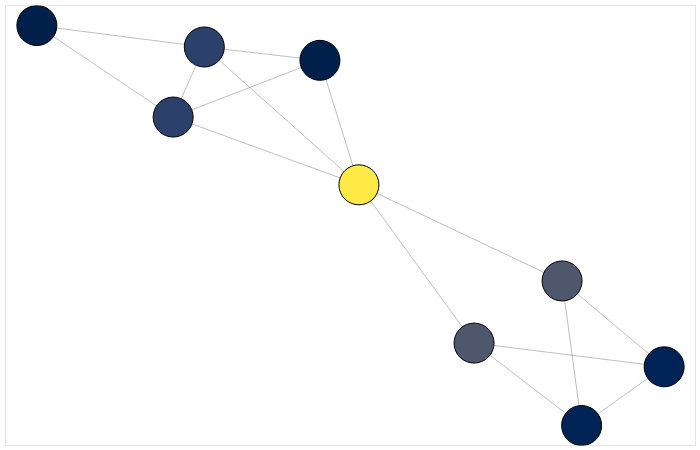

In [27]:
figure_kwargs = {
    'width': 700,
    'height': 450,
    'tooltips': [("betweenness", "@betweenness{0.00}")]
}

plot = plot_example_graph(G, 'betweenness', **figure_kwargs)
get_screenshot_as_png(plot)

### 2.1 Degree <a class="anchor" id="degree"></a>

TBD

In [28]:
degree_graph = nx.Graph()

# let's define edges for a simple graph
edges = [
    ('b', 'o'), ('f', 'u'), ('a', 'b'), ('a', 'c'), ('a', 'd'), ('a', 'e'), 
    ('a', 'f'), ('b', 'c'), ('b', 'd'), ('b', 'e'), ('c', 'd'), ('c', 'e'),
    ('f', 'c'), ('f', 'd'), ('f', 'e'), ('g', 'b'), ('g', 'd'), ('g', 'f')
]

# add edges to the graph
for node_1, node_2 in edges:
    degree_graph.add_edge(node_1, node_2)

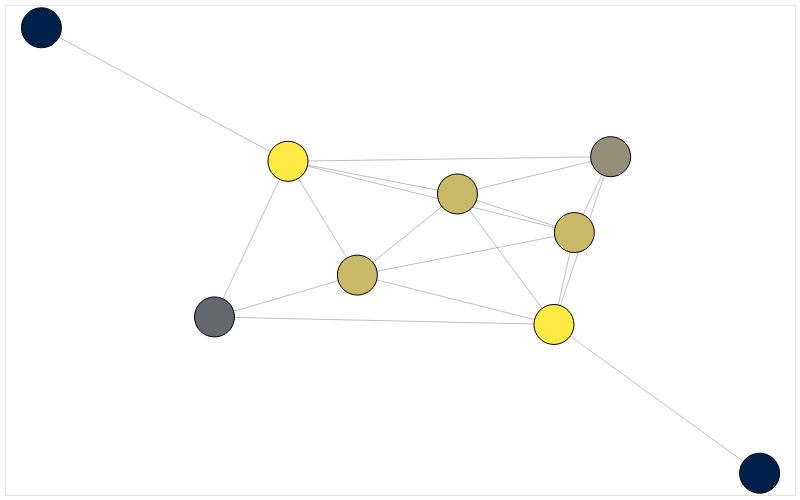

In [30]:
figure_kwargs = {
    'width': 800,
    'height': 500,
    'tooltips': [("degree", "@degree{0.00}"), ("betweenness", "@betweenness{0.00}")]
}

plot = plot_example_graph(degree_graph, color_attribute='degree', **figure_kwargs)
get_screenshot_as_png(plot)

TBD

## 3. Creating the Network Graphs <a class="anchor" id="creating-network"></a>

TBD

### 3.1 Embeddings <a class="anchor" id="embeddings"></a>

TBD

### 3.2 Classification <a class="anchor" id="classification"></a>

TBD

## 4. Correlation Analysis <a class="anchor" id="correlation-analysis"></a>

TBD

## Summary  <a class="anchor" id="summary"></a>

TBD